def plot_categorical_and_continuous_vars(train, cats, quants):
    """
    Function takes in a df, categorical variables, and quantitative variable and returns a violin plot, 
    ked plot, and box plot for each combination of categorical vars to quantitative vars.
    """
    for quant in train[quants]:
        print('-------------------------------------------------')
        print(f'{quant}')
        print('-------------------------------------------------')
        for cat in train[cats]:
            print(f'vs. {cat}')    
            fig = plt.figure(figsize=(20,4))

            #subplot 1
            plt.subplot(131)
            plt.title('Violin Plot')
            sns.violinplot(x=quant, y=cat, data=train, palette="Set2")

            #subplot 2
            plt.subplot(132)
            plt.title('Kernel Density Estimate Plot')
            sns.kdeplot(data=train, x=quant, hue=cat, multiple="stack", shade_lowest=True, palette="Set2")

            #subplot 3
            plt.subplot('133')
            sns.boxenplot(data=train, x=quant, y=cat, palette="Set2")
            plt.title('Box Plot')
            print('---------------')
            plt.show()

# Data Wrangling: Acquisition & Preparation
---
## Acquire (acquire.py)
### Zillow

For the following, iterate through the steps you would take to create functions: Write the code to do the following in a jupyter notebook, test it, convert to functions, then create the file to house those functions.

You will have a zillow.ipynb file and a helper file for each section in the pipeline.

**acquire & summarize**

1. Acquire data from mySQL using the python module to connect and query. You will want to end with a single dataframe. Make sure to include: the logerror, all fields related to the properties that are available. You will end up using all the tables in the database.

2. Be sure to do the correct join (inner, outer, etc.). We do not want to eliminate properties purely because they may have a null value for airconditioningtypeid.
Only include properties with a transaction in 2017, and include only the last transaction for each property (so no duplicate property ID's), along with zestimate error and date of transaction.
Only include properties that include a latitude and longitude value.
Summarize your data (summary stats, info, dtypes, shape, distributions, value_counts, etc.)

3. Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an atttribute name, the first column is the number of rows with missing values for that attribute, and the second column is percent of total rows that have missing values for that attribute. Run the function and document takeaways from this on how you want to handle missing values.

In [1]:
import os
from env import host, user, password
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

################### Connects to Sequel Ace using credentials ###################

def get_connection(db, user=user, host=host, password=password):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    It takes in a string name of a database as an argument.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'


################### Create new dataframe from SQL db ###################
    
def new_zillow_data():
    '''
    This function reads the zillow data from the Codeup db into a df,
    writes it to a csv file, and returns the df.
    '''

    # Create SQL query.
    sql_query = """
            SELECT 	prop.*, 
                ac.airconditioningdesc,
                txn.transactiondate, 
                pred.logerror, 
                ast.architecturalstyledesc,
                bc.buildingclassdesc,
                hs.heatingorsystemdesc,
                plu.propertylandusedesc,
                st.storydesc,
                tc.typeconstructiondesc
            FROM properties_2017 prop
            JOIN (
                SELECT parcelid, max(transactiondate) as transactiondate
                FROM predictions_2017
                GROUP BY parcelid
                ) AS txn ON prop.parcelid = txn.parcelid
            JOIN predictions_2017 AS pred  
            ON prop.parcelid = pred.parcelid 
                AND pred.transactiondate = txn.transactiondate
            LEFT JOIN airconditioningtype AS ac
            USING(airconditioningtypeid)
            LEFT JOIN architecturalstyletype AS ast
            USING (architecturalstyletypeid)
            LEFT JOIN buildingclasstype AS bc
            USING (buildingclasstypeid)
            LEFT JOIN heatingorsystemtype AS hs
            USING (heatingorsystemtypeid)
            LEFT JOIN propertylandusetype AS plu
            USING (propertylandusetypeid)
            LEFT JOIN storytype AS st
            USING (storytypeid)
            LEFT JOIN typeconstructiontype AS tc
            USING (typeconstructiontypeid)
            WHERE COALESCE(prop.longitude, prop.latitude) IS NOT NULL;
                """
    # Read in DataFrame from Codeup's SQL db.
    df = pd.read_sql(sql_query, get_connection('zillow'))
    
    return df


################### Acquire existing csv file ###################

def get_zillow_data():
    '''
    This function reads in zillow data from Codeup database, writes data to
    a csv file if a local file does not exist, and returns a df.
    '''
    if os.path.isfile('zillow.csv'):
        
        # If csv file exists, read in data from csv file.
        df = pd.read_csv('zillow.csv', index_col=0)
        
    else:
        
        # Read fresh data from db into a DataFrame.
        df = new_zillow_data()
        
        # Write DataFrame to a csv file.
        df.to_csv('zillow.csv')
        
    return df
df = get_zillow_data()

In [2]:
df.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,airconditioningdesc,transactiondate,logerror,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,6.059063e+13,NaN,2017-01-01,0.025595,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,...,6.111001e+13,NaN,2017-01-01,0.055619,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,6.059022e+13,NaN,2017-01-01,0.005383,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,6.037300e+13,NaN,2017-01-01,-0.103410,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,6.037124e+13,Central,2017-01-01,0.006940,NaN,NaN,Central,Condominium,NaN,NaN


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,77381.0,1.495139e+06,8.609071e+05,3.490000e+02,7.520700e+05,1.497932e+06,2.240535e+06,2.982274e+06
parcelid,77381.0,1.300715e+07,3.481346e+06,1.071186e+07,1.153830e+07,1.253157e+07,1.421183e+07,1.676893e+08
airconditioningtypeid,24953.0,1.813289e+00,2.967894e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
architecturalstyletypeid,206.0,7.388350e+00,2.734542e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.100000e+01
basementsqft,50.0,6.797200e+02,6.897035e+02,3.800000e+01,2.730000e+02,5.150000e+02,7.965000e+02,3.560000e+03
bathroomcnt,77381.0,2.299130e+00,9.966507e-01,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
bedroomcnt,77381.0,3.053489e+00,1.139096e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.600000e+01
buildingclasstypeid,15.0,3.933333e+00,2.581989e-01,3.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
buildingqualitytypeid,49672.0,6.534587e+00,1.721953e+00,1.000000e+00,6.000000e+00,6.000000e+00,8.000000e+00,1.200000e+01
calculatedbathnbr,76772.0,2.316867e+00,9.797549e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77381 entries, 0 to 77380
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77381 non-null  int64  
 1   parcelid                      77381 non-null  int64  
 2   airconditioningtypeid         24953 non-null  float64
 3   architecturalstyletypeid      206 non-null    float64
 4   basementsqft                  50 non-null     float64
 5   bathroomcnt                   77381 non-null  float64
 6   bedroomcnt                    77381 non-null  float64
 7   buildingclasstypeid           15 non-null     float64
 8   buildingqualitytypeid         49672 non-null  float64
 9   calculatedbathnbr             76772 non-null  float64
 10  decktypeid                    614 non-null    float64
 11  finishedfloor1squarefeet      6023 non-null   float64
 12  calculatedfinishedsquarefeet  77185 non-null  float64
 13  f

In [5]:
df.value_counts

<bound method DataFrame.value_counts of             id  parcelid  airconditioningtypeid  architecturalstyletypeid  \
0      1727539  14297519                    NaN                       NaN   
1      1387261  17052889                    NaN                       NaN   
2        11677  14186244                    NaN                       NaN   
3      2288172  12177905                    NaN                       NaN   
4      1970746  10887214                    1.0                       NaN   
...        ...       ...                    ...                       ...   
77376   673515  11000655                    NaN                       NaN   
77377  2968375  17239384                    NaN                       NaN   
77378  1843709  12773139                    1.0                       NaN   
77379  1187175  12826780                    NaN                       NaN   
77380  2455685  13083743                    NaN                       NaN   

       basementsqft  bathroomcnt  b

In [6]:
df.nunique()

id                          77381
parcelid                    77381
airconditioningtypeid           5
architecturalstyletypeid        5
basementsqft                   43
                            ...  
buildingclassdesc               2
heatingorsystemdesc            10
propertylandusedesc            13
storydesc                       1
typeconstructiondesc            4
Length: 68, dtype: int64

In [7]:
df.shape

(77381, 68)

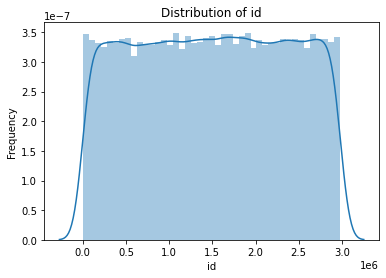

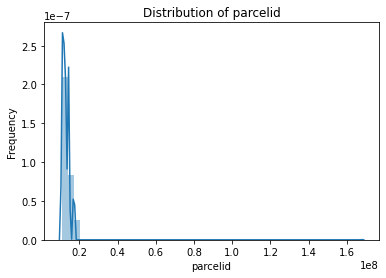

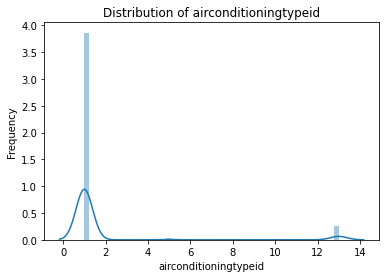

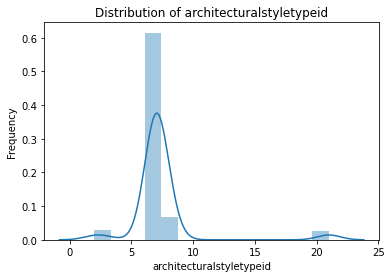

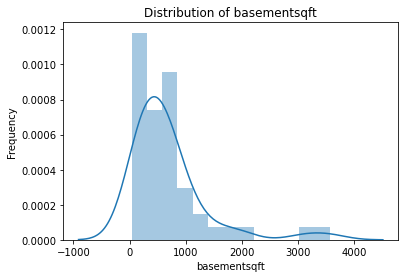

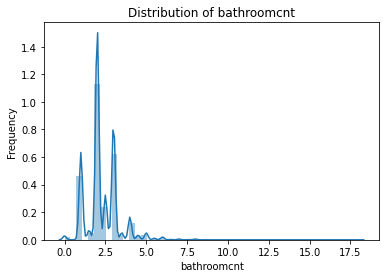

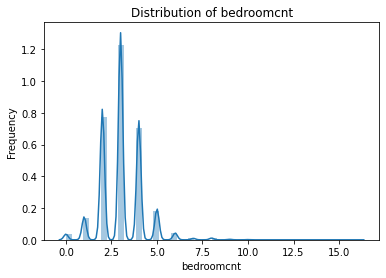

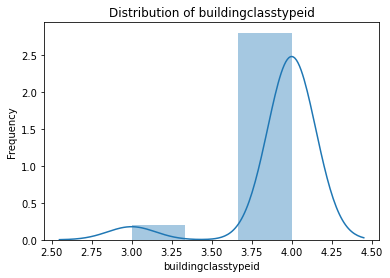

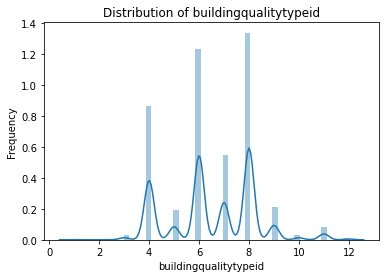

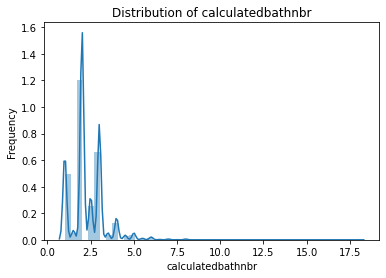

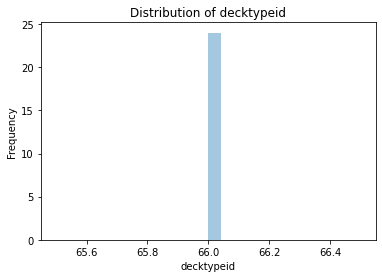

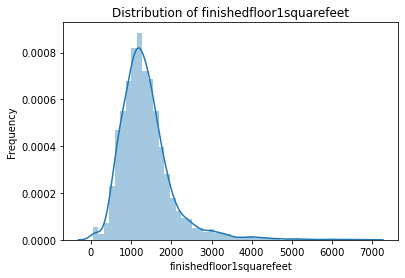

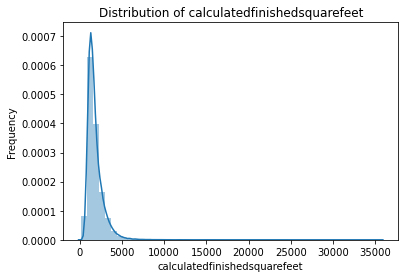

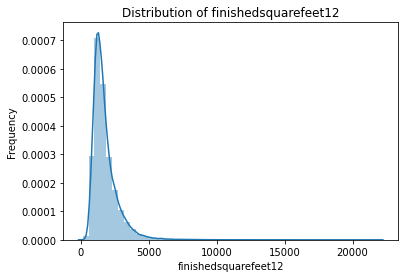

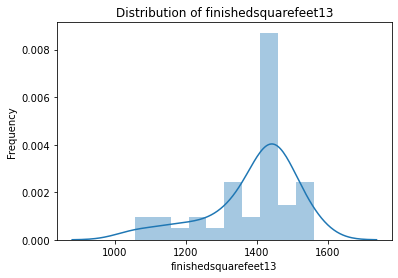

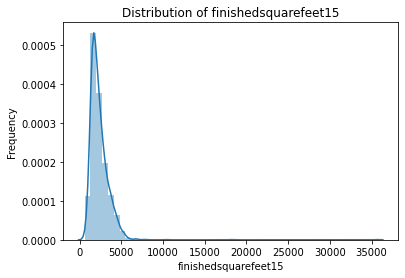

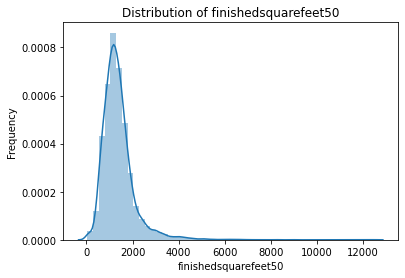

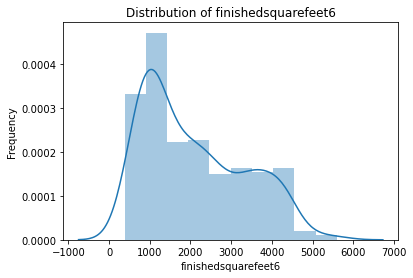

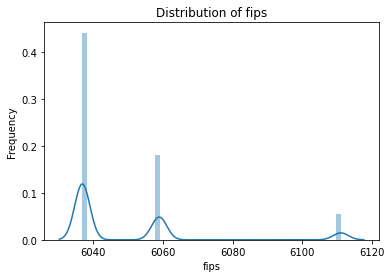

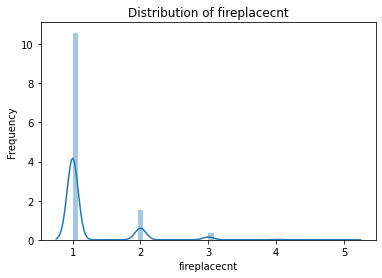

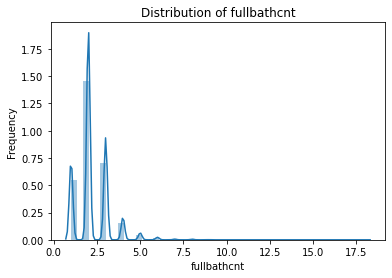

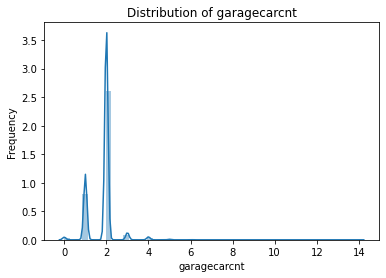

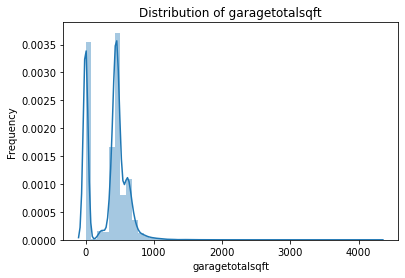

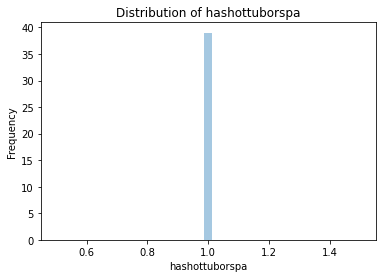

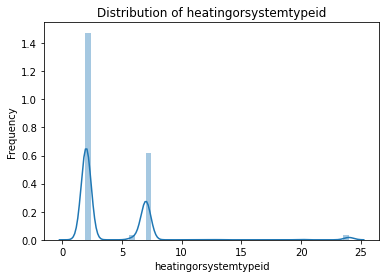

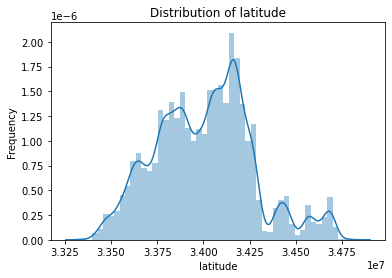

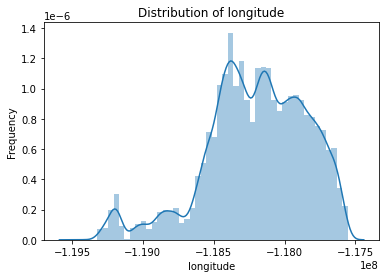

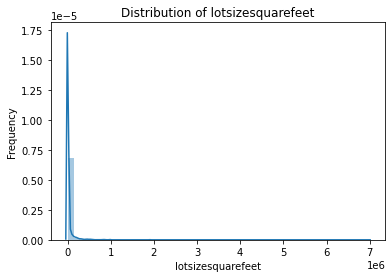

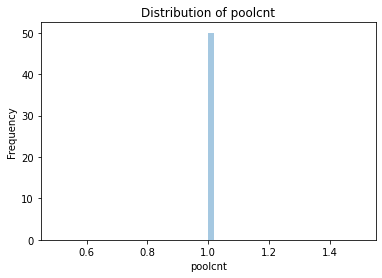

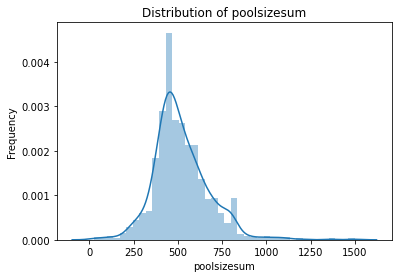

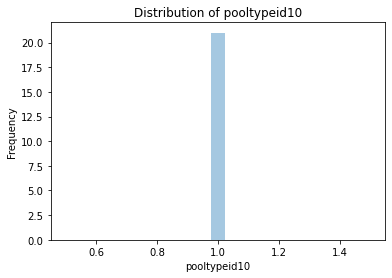

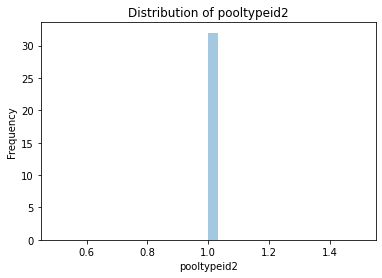

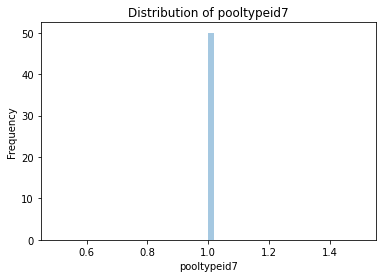

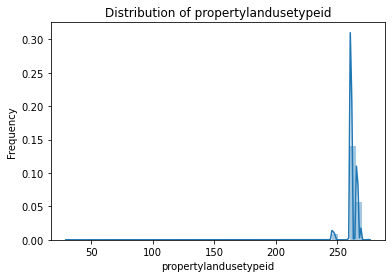

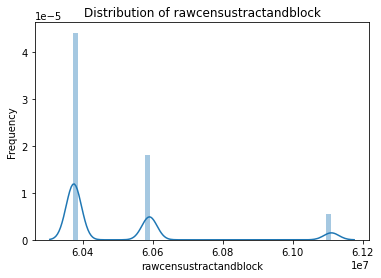

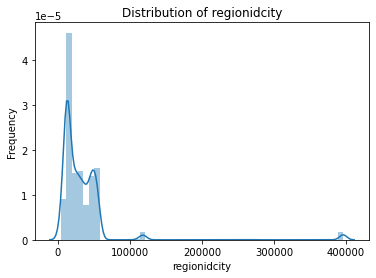

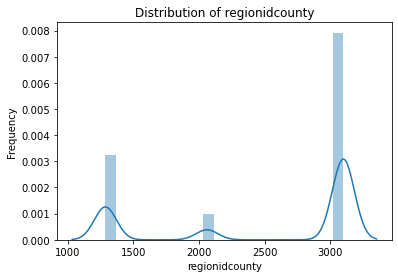

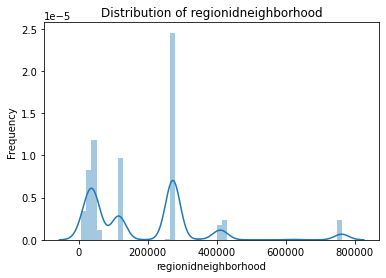

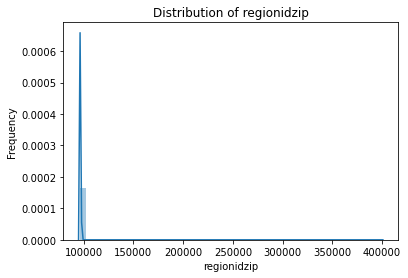

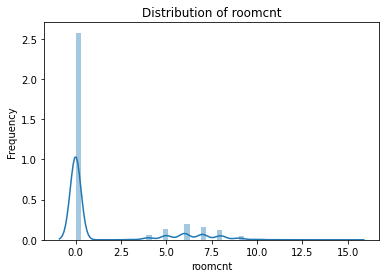

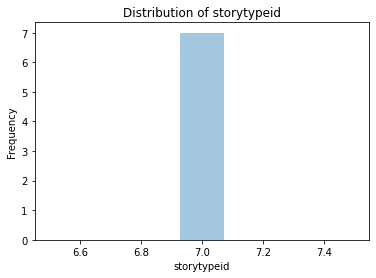

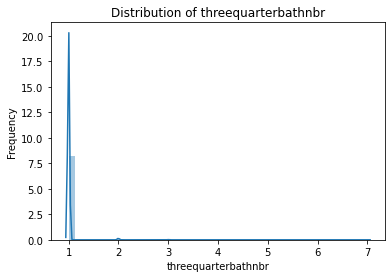

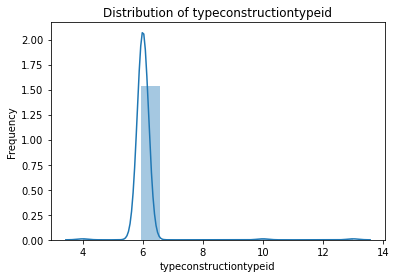

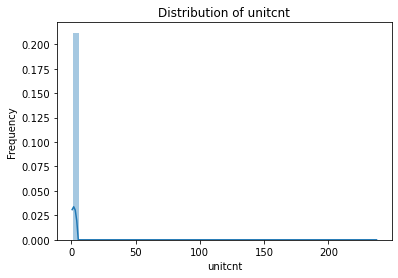

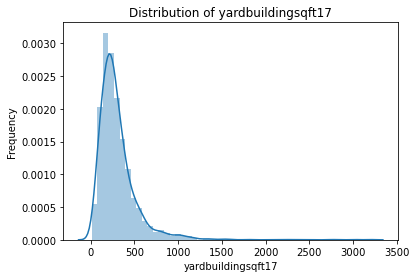

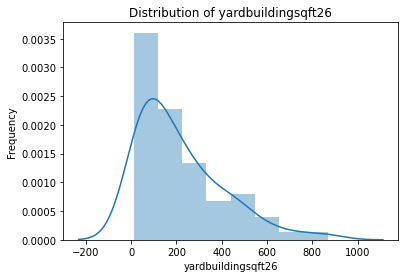

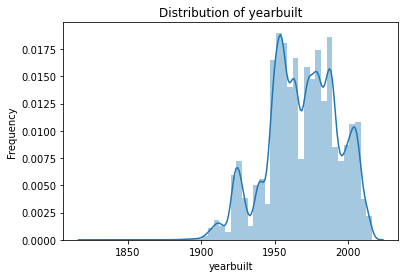

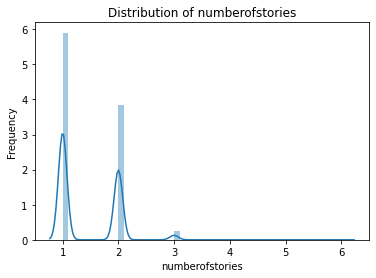

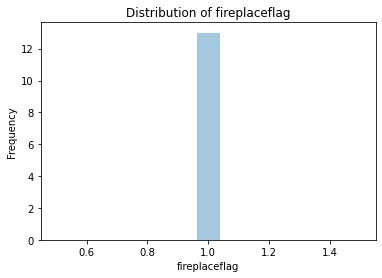

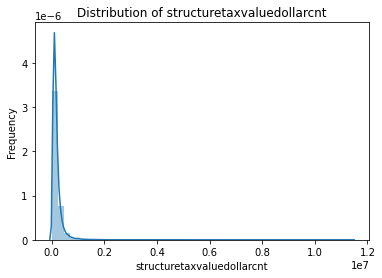

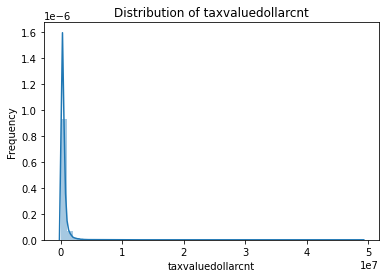

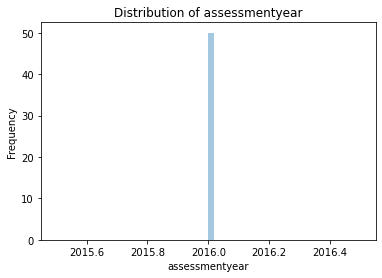

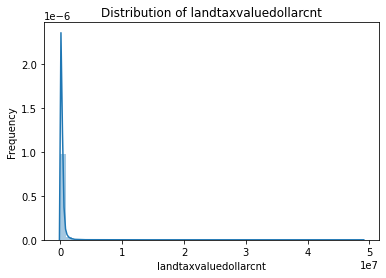

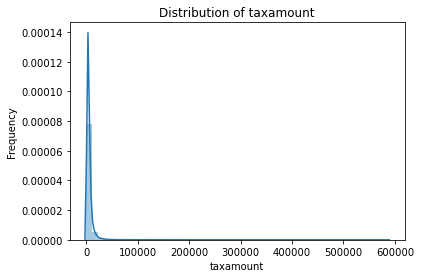

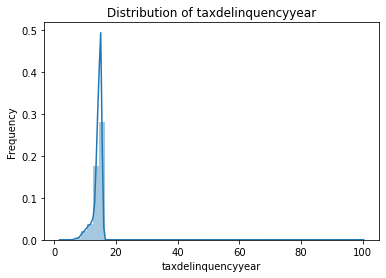

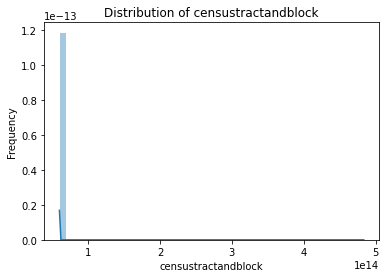

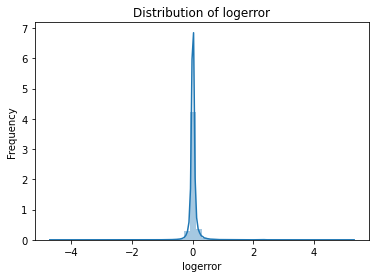

In [8]:
for col in df.columns:
    if df[col].dtype != 'O':
        sns.distplot(df[col])
        plt.title(f'Distribution of {col}')
        plt.ylabel('Frequency')
        plt.xlabel(col)
        plt.show()

YOU CAN'T HANDLE THE STATS!!!!!!
|------------------------------------------------------|
|------------------------------------------------------|
Shape: (77381, 68)
|------------------------------------------------------|
<class 'pandas.core.frame.DataFrame'>
Int64Index: 77381 entries, 0 to 77380
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77381 non-null  int64  
 1   parcelid                      77381 non-null  int64  
 2   airconditioningtypeid         24953 non-null  float64
 3   architecturalstyletypeid      206 non-null    float64
 4   basementsqft                  50 non-null     float64
 5   bathroomcnt                   77381 non-null  float64
 6   bedroomcnt                    77381 non-null  float64
 7   buildingclasstypeid           15 non-null     float64
 8   buildingqualitytypeid         49672 non-null  float64
 9   calculatedbath

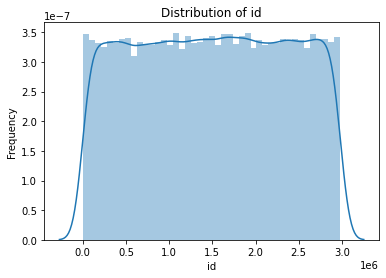

|------------------------------------------------------|
|------------------------------------------------------|
|-------parcelid-------|

dtpye: int64

Null count: 0

count    7.738100e+04
mean     1.300715e+07
std      3.481346e+06
min      1.071186e+07
25%      1.153830e+07
50%      1.253157e+07
75%      1.421183e+07
max      1.676893e+08
Name: parcelid, dtype: float64

11933699    1
11505743    1
11709951    1
11445758    1
14728701    1
           ..
11819678    1
12792914    1
13840735    1
12083865    1
12853244    1
Name: parcelid, Length: 77381, dtype: int64

[14297519 17052889 14186244 ... 12773139 12826780 13083743]



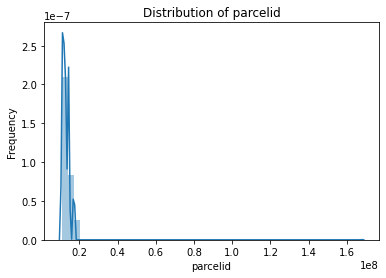

|------------------------------------------------------|
|------------------------------------------------------|
|-------airconditioningtypeid-------|

dtpye: float64

Null count: 52428

count    24953.000000
mean         1.813289
std          2.967894
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         13.000000
Name: airconditioningtypeid, dtype: float64

1.0     23133
13.0     1574
5.0       167
11.0       53
9.0        26
Name: airconditioningtypeid, dtype: int64

[nan  1. 13.  5. 11.  9.]



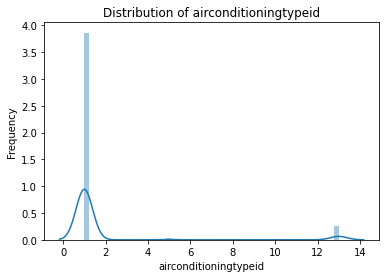

|------------------------------------------------------|
|------------------------------------------------------|
|-------architecturalstyletypeid-------|

dtpye: float64

Null count: 77175

count    206.000000
mean       7.388350
std        2.734542
min        2.000000
25%        7.000000
50%        7.000000
75%        7.000000
max       21.000000
Name: architecturalstyletypeid, dtype: float64

7.0     172
8.0      19
21.0      7
2.0       5
3.0       3
Name: architecturalstyletypeid, dtype: int64

[nan  7.  8. 21.  3.  2.]



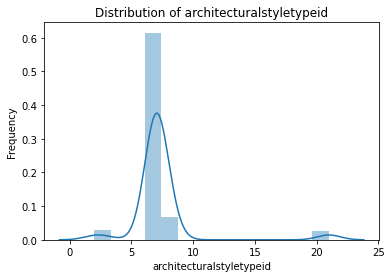

|------------------------------------------------------|
|------------------------------------------------------|
|-------basementsqft-------|

dtpye: float64

Null count: 77331

count      50.000000
mean      679.720000
std       689.703546
min        38.000000
25%       273.000000
50%       515.000000
75%       796.500000
max      3560.000000
Name: basementsqft, dtype: float64

640.0     2
900.0     2
515.0     2
700.0     2
273.0     2
912.0     2
100.0     2
3560.0    1
786.0     1
204.0     1
1416.0    1
512.0     1
38.0      1
1809.0    1
168.0     1
280.0     1
1252.0    1
604.0     1
1218.0    1
396.0     1
645.0     1
314.0     1
819.0     1
600.0     1
200.0     1
380.0     1
252.0     1
384.0     1
669.0     1
394.0     1
224.0     1
3112.0    1
405.0     1
800.0     1
588.0     1
352.0     1
90.0      1
126.0     1
254.0     1
1969.0    1
112.0     1
674.0     1
300.0     1
Name: basementsqft, dtype: int64

[  nan  900. 1416.  224.  100.  512.  380.  204.  515.  273.  200. 

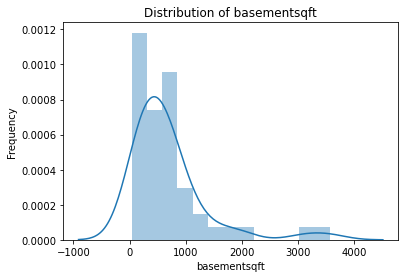

|------------------------------------------------------|
|------------------------------------------------------|
|-------bathroomcnt-------|

dtpye: float64

Null count: 0

count    77381.000000
mean         2.299130
std          0.996651
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         18.000000
Name: bathroomcnt, dtype: float64

2.0     31485
3.0     17313
1.0     12902
2.5      6604
4.0      3352
1.5      1415
3.5      1034
5.0      1026
4.5       695
0.0       592
6.0       417
5.5       224
7.0       113
8.0       108
6.5        47
9.0        23
7.5        16
10.0        7
11.0        3
8.5         3
13.0        1
18.0        1
Name: bathroomcnt, dtype: int64

[ 3.5  1.   2.   3.   0.   2.5  4.5  4.   5.   6.5  1.5  6.   5.5  7.
  9.   8.  10.  11.  18.   7.5 13.   8.5]



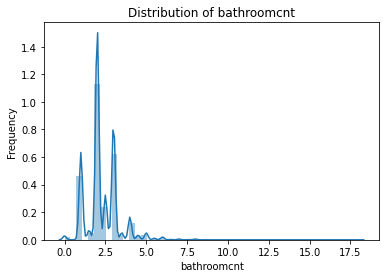

|------------------------------------------------------|
|------------------------------------------------------|
|-------bedroomcnt-------|

dtpye: float64

Null count: 0

count    77381.000000
mean         3.053489
std          1.139096
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         16.000000
Name: bedroomcnt, dtype: float64

3.0     30362
2.0     19169
4.0     17513
5.0      4543
1.0      3379
6.0       998
0.0       830
8.0       252
7.0       208
9.0        70
10.0       31
12.0       14
11.0        8
13.0        2
14.0        1
16.0        1
Name: bedroomcnt, dtype: int64

[ 4.  2.  3.  0.  6.  5.  1.  7.  8. 12. 10.  9. 14. 11. 16. 13.]



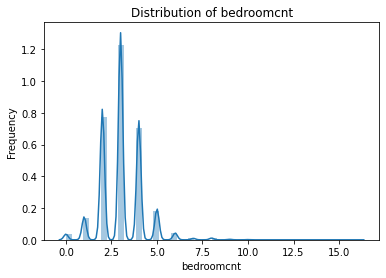

|------------------------------------------------------|
|------------------------------------------------------|
|-------buildingclasstypeid-------|

dtpye: float64

Null count: 77366

count    15.000000
mean      3.933333
std       0.258199
min       3.000000
25%       4.000000
50%       4.000000
75%       4.000000
max       4.000000
Name: buildingclasstypeid, dtype: float64

4.0    14
3.0     1
Name: buildingclasstypeid, dtype: int64

[nan  4.  3.]



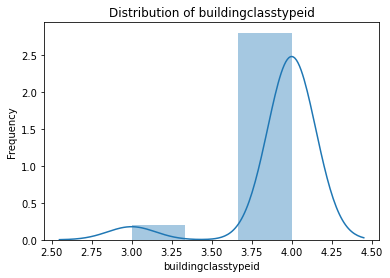

|------------------------------------------------------|
|------------------------------------------------------|
|-------buildingqualitytypeid-------|

dtpye: float64

Null count: 27709

count    49672.000000
mean         6.534587
std          1.721953
min          1.000000
25%          6.000000
50%          6.000000
75%          8.000000
max         12.000000
Name: buildingqualitytypeid, dtype: float64

8.0     14645
6.0     13462
4.0      9483
7.0      5971
9.0      2299
5.0      2088
11.0      931
3.0       329
10.0      313
12.0      116
1.0        26
2.0         9
Name: buildingqualitytypeid, dtype: int64

[nan  8.  9.  5.  4.  6.  7. 10.  3. 11. 12.  1.  2.]



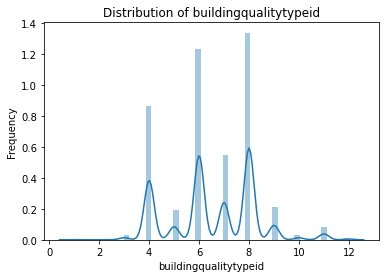

|------------------------------------------------------|
|------------------------------------------------------|
|-------calculatedbathnbr-------|

dtpye: float64

Null count: 609

count    76772.000000
mean         2.316867
std          0.979755
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         18.000000
Name: calculatedbathnbr, dtype: float64

2.0     31485
3.0     17313
1.0     12902
2.5      6595
4.0      3352
1.5      1408
3.5      1034
5.0      1026
4.5       695
6.0       417
5.5       223
7.0       113
8.0       108
6.5        47
9.0        23
7.5        16
10.0        7
11.0        3
8.5         3
13.0        1
18.0        1
Name: calculatedbathnbr, dtype: int64

[ 3.5  1.   2.   3.   nan  2.5  4.5  4.   5.   6.5  1.5  6.   5.5  7.
  9.   8.  10.  11.  18.   7.5 13.   8.5]



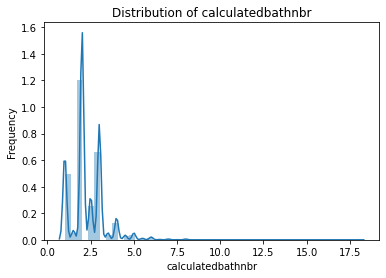

|------------------------------------------------------|
|------------------------------------------------------|
|-------decktypeid-------|

dtpye: float64

Null count: 76767

count    614.0
mean      66.0
std        0.0
min       66.0
25%       66.0
50%       66.0
75%       66.0
max       66.0
Name: decktypeid, dtype: float64

66.0    614
Name: decktypeid, dtype: int64

[nan 66.]



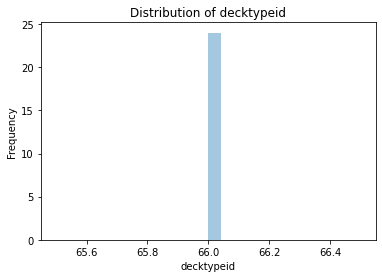

|------------------------------------------------------|
|------------------------------------------------------|
|-------finishedfloor1squarefeet-------|

dtpye: float64

Null count: 71358

count    6023.000000
mean     1366.512535
std       671.308125
min        44.000000
25%       955.000000
50%      1257.000000
75%      1615.000000
max      6912.000000
Name: finishedfloor1squarefeet, dtype: float64

1252.0    22
1205.0    21
1441.0    21
1462.0    21
1498.0    21
          ..
859.0      1
1480.0     1
2440.0     1
2273.0     1
2116.0     1
Name: finishedfloor1squarefeet, Length: 1787, dtype: int64

[  nan 1465.  842. ... 5774.  943. 2652.]



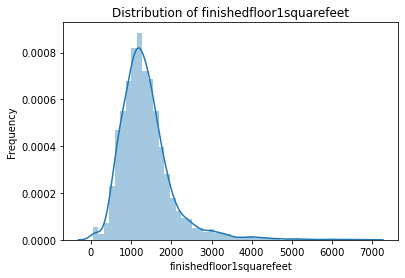

|------------------------------------------------------|
|------------------------------------------------------|
|-------calculatedfinishedsquarefeet-------|

dtpye: float64

Null count: 196

count    77185.000000
mean      1785.219939
std        954.049286
min        128.000000
25%       1182.000000
50%       1543.000000
75%       2113.000000
max      35640.000000
Name: calculatedfinishedsquarefeet, dtype: float64

1200.0     181
1120.0     169
1440.0     147
1080.0     132
1260.0     120
          ... 
4394.0       1
11020.0      1
3688.0       1
4685.0       1
5009.0       1
Name: calculatedfinishedsquarefeet, Length: 4972, dtype: int64

[3100. 1465. 1243. ... 3820. 5655. 5210.]



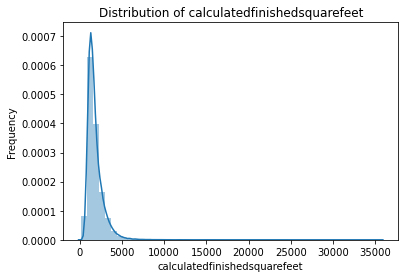

|------------------------------------------------------|
|------------------------------------------------------|
|-------finishedsquarefeet12-------|

dtpye: float64

Null count: 3632

count    73749.000000
mean      1760.522543
std        934.024340
min        128.000000
25%       1172.000000
50%       1523.000000
75%       2076.000000
max      21929.000000
Name: finishedsquarefeet12, dtype: float64

1200.0    176
1120.0    165
1080.0    131
1440.0    120
1232.0    116
         ... 
603.0       1
4339.0      1
6620.0      1
6469.0      1
4179.0      1
Name: finishedsquarefeet12, Length: 4868, dtype: int64

[3100. 1465. 1243. ... 4530. 5655. 5210.]



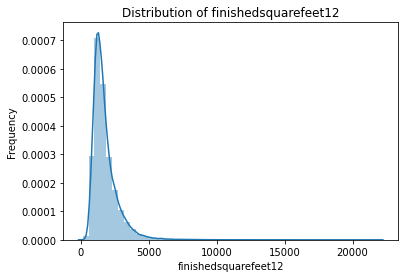

|------------------------------------------------------|
|------------------------------------------------------|
|-------finishedsquarefeet13-------|

dtpye: float64

Null count: 77340

count      41.000000
mean     1389.853659
std       123.531688
min      1056.000000
25%      1344.000000
50%      1440.000000
75%      1440.000000
max      1560.000000
Name: finishedsquarefeet13, dtype: float64

1440.0    18
1344.0     5
1536.0     3
1488.0     3
1248.0     2
1392.0     2
1152.0     2
1200.0     1
1056.0     1
1060.0     1
1512.0     1
1300.0     1
1560.0     1
Name: finishedsquarefeet13, dtype: int64

[  nan 1440. 1344. 1152. 1536. 1392. 1056. 1248. 1300. 1560. 1488. 1512.
 1060. 1200.]



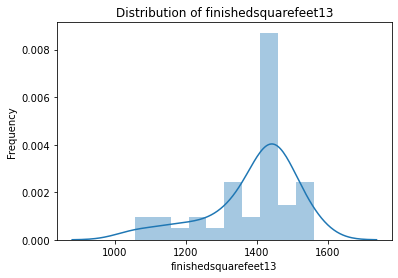

|------------------------------------------------------|
|------------------------------------------------------|
|-------finishedsquarefeet15-------|

dtpye: float64

Null count: 74372

count     3009.000000
mean      2357.791625
std       1188.775210
min        598.000000
25%       1625.000000
50%       2094.000000
75%       2838.000000
max      35640.000000
Name: finishedsquarefeet15, dtype: float64

1680.0    16
1536.0    12
2016.0    12
1600.0    10
1560.0     9
          ..
3035.0     1
4083.0     1
3972.0     1
2641.0     1
3350.0     1
Name: finishedsquarefeet15, Length: 1724, dtype: int64

[  nan 3435. 3626. ... 4175. 1228. 4422.]



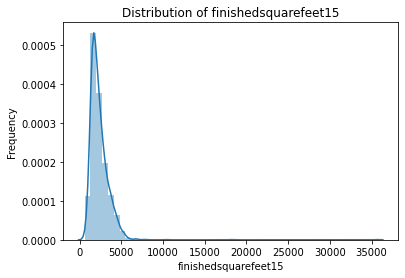

|------------------------------------------------------|
|------------------------------------------------------|
|-------finishedsquarefeet50-------|

dtpye: float64

Null count: 71358

count     6023.000000
mean      1381.771542
std        726.468878
min         44.000000
25%        956.000000
50%       1259.000000
75%       1621.500000
max      12467.000000
Name: finishedsquarefeet50, dtype: float64

1252.0    22
1205.0    21
1462.0    21
1441.0    21
780.0     21
          ..
2176.0     1
2536.0     1
2150.0     1
995.0      1
487.0      1
Name: finishedsquarefeet50, Length: 1807, dtype: int64

[  nan 1465.  842. ... 5774.  943. 2652.]



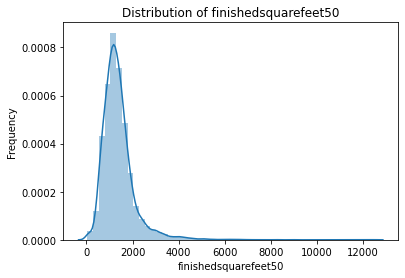

|------------------------------------------------------|
|------------------------------------------------------|
|-------finishedsquarefeet6-------|

dtpye: float64

Null count: 76995

count     386.000000
mean     2082.500000
std      1240.382784
min       380.000000
25%       993.750000
50%      1812.500000
75%      3053.500000
max      5598.000000
Name: finishedsquarefeet6, dtype: float64

952.0     4
520.0     3
3552.0    3
3500.0    3
750.0     3
         ..
4572.0    1
1363.0    1
744.0     1
3073.0    1
1854.0    1
Name: finishedsquarefeet6, Length: 350, dtype: int64

[  nan 2482.  624. 4198. 5041. 1482.  750. 1132. 4468. 1235.  520. 4380.
  908.  600. 2792. 2298. 2515. 1950. 1360.  856.  688.  634. 4109.  938.
 4414.  956. 2635. 1012. 2030. 1792. 4086. 1517.  989. 1214.  784. 4302.
 3280.  811.  952. 1652. 3462. 3709. 2470.  964.  837. 3829. 1242. 1220.
 3001. 1832. 1380. 1320. 3169.  845. 3500. 3423. 4411. 1085. 4233.  940.
 1498.  826. 2625. 2445. 2965. 1064.  926. 3044. 303

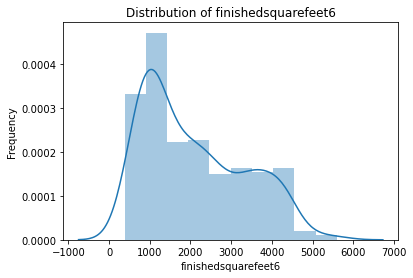

|------------------------------------------------------|
|------------------------------------------------------|
|-------fips-------|

dtpye: float64

Null count: 0

count    77381.000000
mean      6048.819232
std         20.748199
min       6037.000000
25%       6037.000000
50%       6037.000000
75%       6059.000000
max       6111.000000
Name: fips, dtype: float64

6037.0    50551
6059.0    20593
6111.0     6237
Name: fips, dtype: int64

[6059. 6111. 6037.]



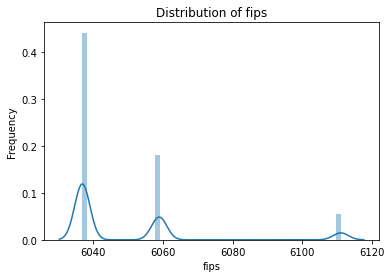

|------------------------------------------------------|
|------------------------------------------------------|
|-------fireplacecnt-------|

dtpye: float64

Null count: 69105

count    8276.000000
mean        1.191155
std         0.491080
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         5.000000
Name: fireplacecnt, dtype: float64

1.0    7008
2.0     995
3.0     235
4.0      35
5.0       3
Name: fireplacecnt, dtype: int64

[nan  1.  2.  3.  4.  5.]



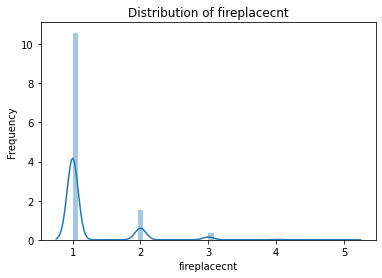

|------------------------------------------------------|
|------------------------------------------------------|
|-------fullbathcnt-------|

dtpye: float64

Null count: 609

count    76772.000000
mean         2.250482
std          0.966552
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         18.000000
Name: fullbathcnt, dtype: float64

2.0     38097
3.0     18351
1.0     14310
4.0      4048
5.0      1245
6.0       454
7.0       121
8.0       111
9.0        23
10.0        7
11.0        3
18.0        1
13.0        1
Name: fullbathcnt, dtype: int64

[ 3.  1.  2. nan  4.  5.  6.  7.  9.  8. 10. 11. 18. 13.]



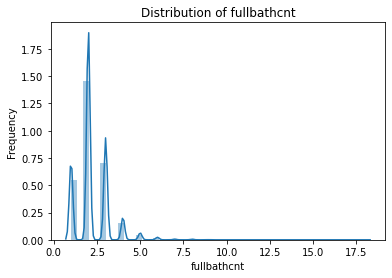

|------------------------------------------------------|
|------------------------------------------------------|
|-------garagecarcnt-------|

dtpye: float64

Null count: 51907

count    25474.000000
mean         1.815459
std          0.588345
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max         14.000000
Name: garagecarcnt, dtype: float64

2.0     18608
1.0      5676
3.0       632
4.0       255
0.0       230
5.0        45
6.0        14
7.0         4
10.0        3
8.0         2
9.0         2
14.0        1
11.0        1
13.0        1
Name: garagecarcnt, dtype: int64

[ 2.  1. nan  3.  4.  0.  5.  7.  6. 10.  8.  9. 11. 13. 14.]



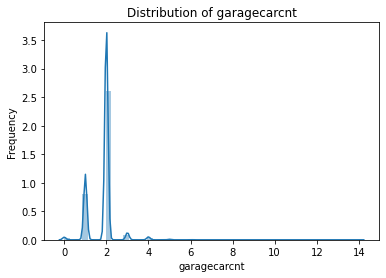

|------------------------------------------------------|
|------------------------------------------------------|
|-------garagetotalsqft-------|

dtpye: float64

Null count: 51907

count    25474.000000
mean       350.111957
std        261.681641
min          0.000000
25%          0.000000
50%        436.000000
75%        493.000000
max       4251.000000
Name: garagetotalsqft, dtype: float64

0.0       7685
400.0      786
441.0      678
462.0      658
360.0      646
          ... 
872.0        1
1096.0       1
921.0        1
918.0        1
877.0        1
Name: garagetotalsqft, Length: 839, dtype: int64

[ 633.    0.  440.   nan  420.  447.  485.  446.  720.  744.  448.  704.
  465.  589.  504.  452. 1114.  460.  491.  636.  441.  630.  638.  444.
  495.  400.  540.  351.  360.  575.  468.  437.  216.  484.  828.  483.
  577.  532.  552.  620.  605.  616.  667.  706.  697.  651.  200.  428.
  480.  582.  665.  464.  451.  439.  677.  467.  595.  528.  231.  407.
  670.  458.  517.  587

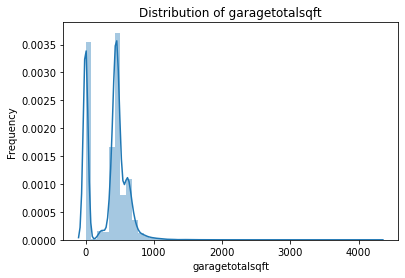

|------------------------------------------------------|
|------------------------------------------------------|
|-------hashottuborspa-------|

dtpye: float64

Null count: 75843

count    1538.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: hashottuborspa, dtype: float64

1.0    1538
Name: hashottuborspa, dtype: int64

[nan  1.]



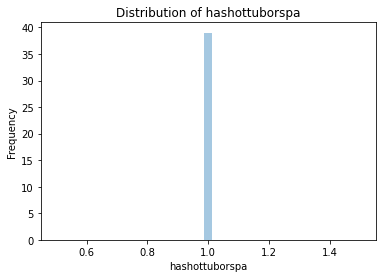

|------------------------------------------------------|
|------------------------------------------------------|
|-------heatingorsystemtypeid-------|

dtpye: float64

Null count: 27941

count    49440.000000
mean         3.920510
std          3.592779
min          1.000000
25%          2.000000
50%          2.000000
75%          7.000000
max         24.000000
Name: heatingorsystemtypeid, dtype: float64

2.0     33550
7.0     14065
24.0      846
6.0       776
20.0      104
13.0       59
18.0       23
1.0        13
10.0        3
11.0        1
Name: heatingorsystemtypeid, dtype: int64

[nan  2.  7.  6. 24. 13. 18. 20.  1. 10. 11.]



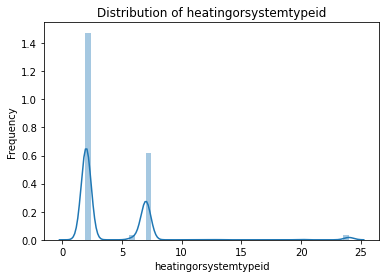

|------------------------------------------------------|
|------------------------------------------------------|
|-------latitude-------|

dtpye: float64

Null count: 0

count    7.738100e+04
mean     3.400837e+07
std      2.653888e+05
min      3.333953e+07
25%      3.381457e+07
50%      3.402200e+07
75%      3.417439e+07
max      3.481877e+07
Name: latitude, dtype: float64

33984600.0    40
33665651.0    38
33766300.0    34
34056700.0    32
34225100.0    29
              ..
34273126.0     1
33489003.0     1
33858091.0     1
34360024.0     1
33763912.0     1
Name: latitude, Length: 64038, dtype: int64

[33634931. 34449266. 33886168. ... 34040895. 33937685. 34010864.]



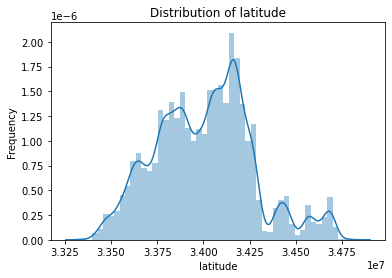

|------------------------------------------------------|
|------------------------------------------------------|
|-------longitude-------|

dtpye: float64

Null count: 0

count    7.738100e+04
mean    -1.182036e+08
std      3.594826e+05
min     -1.194754e+08
25%     -1.184153e+08
50%     -1.181808e+08
75%     -1.179284e+08
max     -1.175546e+08
Name: longitude, dtype: float64

-118438000.0    63
-118435000.0    62
-118390000.0    60
-118445000.0    60
-118377000.0    59
                ..
-118416679.0     1
-117577117.0     1
-118365675.0     1
-118287356.0     1
-118105060.0     1
Name: longitude, Length: 62461, dtype: int64

[-1.17869207e+08 -1.19281531e+08 -1.17823170e+08 ... -1.18038169e+08
 -1.17996709e+08 -1.17900894e+08]



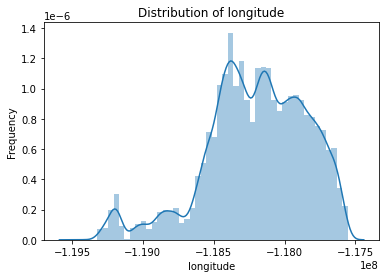

|------------------------------------------------------|
|------------------------------------------------------|
|-------lotsizesquarefeet-------|

dtpye: float64

Null count: 8239

count    6.914200e+04
mean     2.996928e+04
std      1.233711e+05
min      2.360000e+02
25%      5.700000e+03
50%      7.206000e+03
75%      1.183100e+04
max      6.971010e+06
Name: lotsizesquarefeet, dtype: float64

6000.0     892
5000.0     437
7200.0     314
7000.0     297
6500.0     294
          ... 
22544.0      1
3047.0       1
28022.0      1
12405.0      1
16446.0      1
Name: lotsizesquarefeet, Length: 18848, dtype: int64

[ 4506. 12647.  8432. ... 45398. 57110. 47405.]



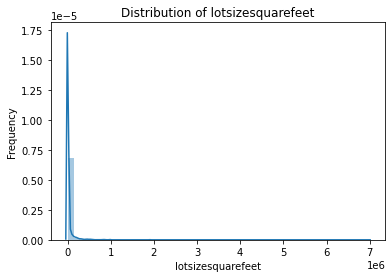

|------------------------------------------------------|
|------------------------------------------------------|
|-------poolcnt-------|

dtpye: float64

Null count: 61244

count    16137.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: poolcnt, dtype: float64

1.0    16137
Name: poolcnt, dtype: int64

[nan  1.]



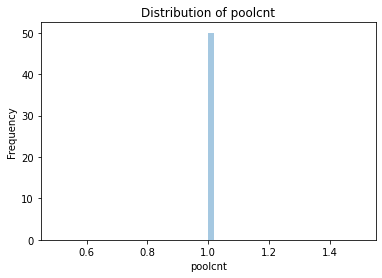

|------------------------------------------------------|
|------------------------------------------------------|
|-------poolsizesum-------|

dtpye: float64

Null count: 76514

count     867.000000
mean      517.916955
std       156.716017
min        24.000000
25%       424.000000
50%       500.000000
75%       600.000000
max      1500.000000
Name: poolsizesum, dtype: float64

450.0    90
400.0    38
500.0    30
600.0    27
800.0    25
         ..
688.0     1
773.0     1
561.0     1
309.0     1
555.0     1
Name: poolsizesum, Length: 262, dtype: int64

[  nan  400.  578.  325.  480.  360.  500.  570.  794.  560.  646.  375.
  600.  800.  450.  760.  832.  372.  405.  820.  525.  324.  550.  288.
  576.  640.  747.  460.  129.  740.  562.  655.  504.  544.  350.  467.
  557.  448.  230.  554.  663.  615.  420.  602.  675.  512.   24.  200.
  451. 1500.  764.  700.  540.  290.  595.  459.  430.  510.  495.  648.
  592.  702.  390.  476.  172.  240.  799.  684.  710.  387.  340.  440.
  2

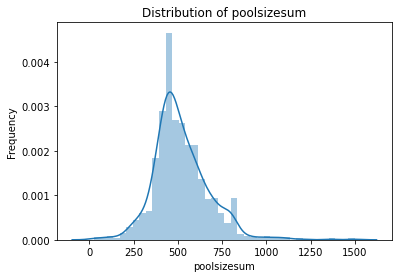

|------------------------------------------------------|
|------------------------------------------------------|
|-------pooltypeid10-------|

dtpye: float64

Null count: 76917

count    464.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: pooltypeid10, dtype: float64

1.0    464
Name: pooltypeid10, dtype: int64

[nan  1.]



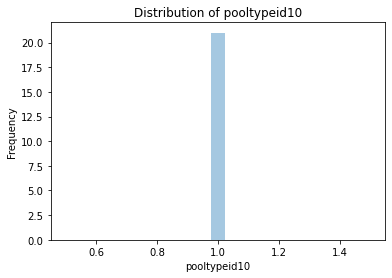

|------------------------------------------------------|
|------------------------------------------------------|
|-------pooltypeid2-------|

dtpye: float64

Null count: 76307

count    1074.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: pooltypeid2, dtype: float64

1.0    1074
Name: pooltypeid2, dtype: int64

[nan  1.]



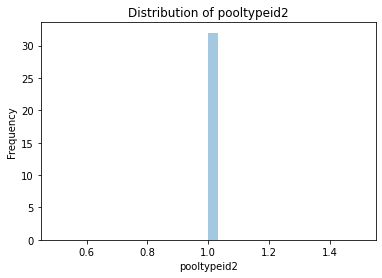

|------------------------------------------------------|
|------------------------------------------------------|
|-------pooltypeid7-------|

dtpye: float64

Null count: 62339

count    15042.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: pooltypeid7, dtype: float64

1.0    15042
Name: pooltypeid7, dtype: int64

[nan  1.]



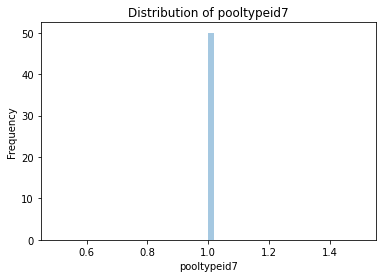

|------------------------------------------------------|
|------------------------------------------------------|
|-------propertycountylandusecode-------|

dtpye: object

Null count: 0

count     77381
unique       75
top        0100
freq      26714
Name: propertycountylandusecode, dtype: object

0100    26714
122     13045
010C     8813
0101     6399
34       4922
        ...  
030G        1
0131        1
020M        1
0133        1
020E        1
Name: propertycountylandusecode, Length: 75, dtype: int64

['122' '1110' '0101' '010C' '1129' '0100' '38' '34' '1111' '012C' '010V'
 '1' '0103' '010D' '0200' '010E' '0300' '96' '0104' '0400' '01DC' '01HC'
 '1321' '1410' '0108' '1128' '010G' '1720' '010H' '1210' '0102' '010F'
 '010M' '1117' '0201' '0700' '1722' '73' '0109' '0301' '01HE' '135' '0204'
 '0401' '070D' '0113' '0133' '0131' '1432' '040G' '1112' '1222' '1310'
 '1120' '0111' '1116' '1421' '0110' '0105' '012E' '0141' '1333' '0115'
 '040V' '010L' '040B' '012D' '0114' '0203' '030G' '013

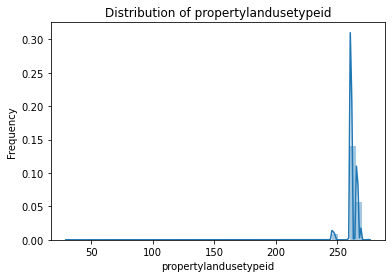

|------------------------------------------------------|
|------------------------------------------------------|
|-------propertyzoningdesc-------|

dtpye: object

Null count: 27050

count     50331
unique     1907
top        LAR1
freq       6747
Name: propertyzoningdesc, dtype: object

LAR1          6747
LAR3          2437
LARS          1389
LBR1N         1222
LARD1.5       1127
              ... 
DOC1*            1
HBC3*            1
RPOH-RS1*        1
ARR 2            1
LAR1-1(T)-       1
Name: propertyzoningdesc, Length: 1907, dtype: int64

[nan 'LCR110000*' 'LAR3' ... 'HAR4-R2*' 'LCR1VV' 'BFA15000*']

|------------------------------------------------------|
|------------------------------------------------------|
|-------rawcensustractandblock-------|

dtpye: float64

Null count: 0

count    7.738100e+04
mean     6.049129e+07
std      2.059052e+05
min      6.037101e+07
25%      6.037311e+07
50%      6.037603e+07
75%      6.059042e+07
max      6.111009e+07
Name: rawcensustractandb

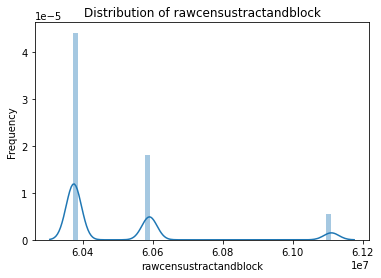

|------------------------------------------------------|
|------------------------------------------------------|
|-------regionidcity-------|

dtpye: float64

Null count: 1471

count     75910.000000
mean      33671.242708
std       47169.815982
min        3491.000000
25%       12447.000000
50%       25218.000000
75%       45457.000000
max      396556.000000
Name: regionidcity, dtype: float64

12447.0     17948
46298.0      2588
5534.0       1912
54311.0      1880
52650.0      1669
            ...  
118880.0        5
13311.0         5
10815.0         4
36078.0         1
21395.0         1
Name: regionidcity, Length: 175, dtype: int64

[ 53571.  13091.  21412. 396551.  12447.  51239.  47019.  45457.  14634.
  54311.     nan  25218.  24832.   8384.  13150.  32380.  17882.   6395.
  25458.  52650.  46298.  40081.  54053.  33252.  12520.  46080.  25459.
  45888.  11626.  13693.  52835.  37015.  14111. 118694.  34636.  17686.
  20008.  15554.  39308.  12292.  38980.  27491.  10723.  27110. 

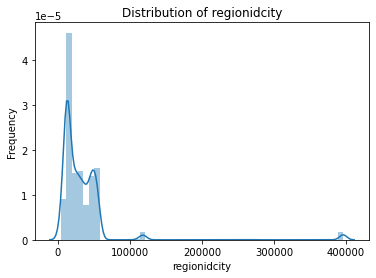

|------------------------------------------------------|
|------------------------------------------------------|
|-------regionidcounty-------|

dtpye: float64

Null count: 0

count    77381.000000
mean      2534.158333
std        801.593352
min       1286.000000
25%       1286.000000
50%       3101.000000
75%       3101.000000
max       3101.000000
Name: regionidcounty, dtype: float64

3101.0    50551
1286.0    20593
2061.0     6237
Name: regionidcounty, dtype: int64

[1286. 2061. 3101.]



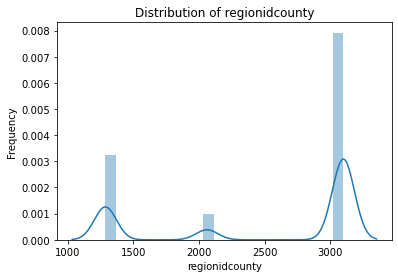

|------------------------------------------------------|
|------------------------------------------------------|
|-------regionidneighborhood-------|

dtpye: float64

Null count: 46491

count     30890.000000
mean     187734.864066
std      165118.791740
min        6952.000000
25%       46736.000000
50%      118849.000000
75%      274765.000000
max      764167.000000
Name: regionidneighborhood, dtype: float64

27080.0     717
48570.0     704
37739.0     684
118208.0    669
51906.0     549
           ... 
762934.0      1
761000.0      1
764144.0      1
268291.0      1
416311.0      1
Name: regionidneighborhood, Length: 480, dtype: int64

[    nan 268548. 274684. 276258. 403184.  37739. 274582. 274815. 268496.
  19810. 416316.  28119.  26134. 274359.  46795. 276486.  51906.  41131.
 274514. 274695. 275024. 268002.  41466. 762930. 274358.  31817. 276023.
 116646.  48570.  40215. 118208. 274049. 268473. 268509. 416302. 113749.
   6952. 268551. 274513. 118872. 268572. 275470.  37835. 26840

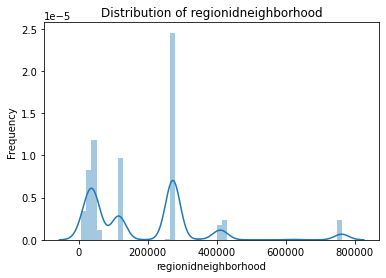

|------------------------------------------------------|
|------------------------------------------------------|
|-------regionidzip-------|

dtpye: float64

Null count: 50

count     77331.000000
mean      96587.086822
std        3798.347098
min       95982.000000
25%       96193.000000
50%       96389.000000
75%       96987.000000
max      399675.000000
Name: regionidzip, dtype: float64

97319.0    825
96987.0    753
97318.0    708
97118.0    613
96974.0    593
          ... 
96500.0      2
97092.0      1
97088.0      1
96467.0      1
97111.0      1
Name: regionidzip, Length: 389, dtype: int64

[ 96978.  97099.  97078.  96330.  96451.  97091.  96293.  96325.  96173.
  96047.  96374.  96956.  96966.  97051.  97008.  97107.  96962.  96275.
  96003.  96220.  96971.  96954.  96018.  96120.  96237.  96957.  96352.
  96008.  97005.  96122.  97067.  96116.  96271.  96946.  96446.  96349.
  96987.  96980.  96450.  96447.  96000.  96291.  96292.  96016.  96133.
  96486.  96361.  96983.  9699

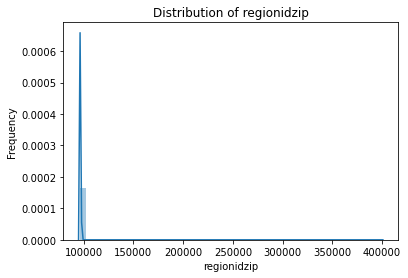

|------------------------------------------------------|
|------------------------------------------------------|
|-------roomcnt-------|

dtpye: float64

Null count: 0

count    77381.000000
mean         1.476952
std          2.824386
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         15.000000
Name: roomcnt, dtype: float64

0.0     59808
6.0      4513
7.0      3838
5.0      3016
8.0      2872
4.0      1415
9.0      1193
10.0      339
3.0       211
11.0      108
12.0       35
2.0        15
13.0       10
14.0        6
15.0        1
1.0         1
Name: roomcnt, dtype: int64

[ 0.  5.  6.  8.  7. 11.  3.  4.  9. 10. 13. 12.  2. 14.  1. 15.]



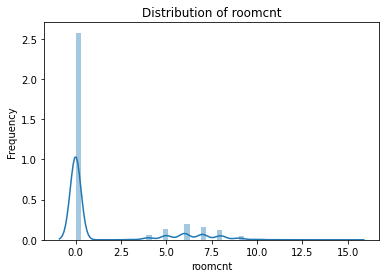

|------------------------------------------------------|
|------------------------------------------------------|
|-------storytypeid-------|

dtpye: float64

Null count: 77331

count    50.0
mean      7.0
std       0.0
min       7.0
25%       7.0
50%       7.0
75%       7.0
max       7.0
Name: storytypeid, dtype: float64

7.0    50
Name: storytypeid, dtype: int64

[nan  7.]



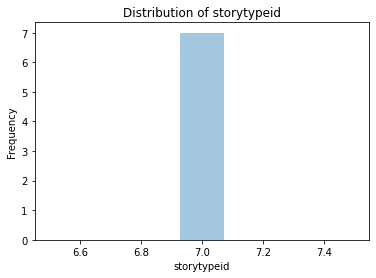

|------------------------------------------------------|
|------------------------------------------------------|
|-------threequarterbathnbr-------|

dtpye: float64

Null count: 67285

count    10096.000000
mean         1.009608
std          0.118630
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          7.000000
Name: threequarterbathnbr, dtype: float64

1.0    10012
2.0       75
3.0        8
7.0        1
Name: threequarterbathnbr, dtype: int64

[ 1. nan  2.  7.  3.]



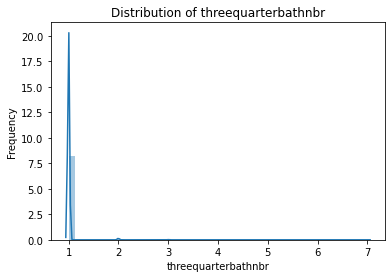

|------------------------------------------------------|
|------------------------------------------------------|
|-------typeconstructiontypeid-------|

dtpye: float64

Null count: 77159

count    222.000000
mean       6.040541
std        0.557285
min        4.000000
25%        6.000000
50%        6.000000
75%        6.000000
max       13.000000
Name: typeconstructiontypeid, dtype: float64

6.0     219
4.0       1
13.0      1
10.0      1
Name: typeconstructiontypeid, dtype: int64

[nan  6. 13. 10.  4.]



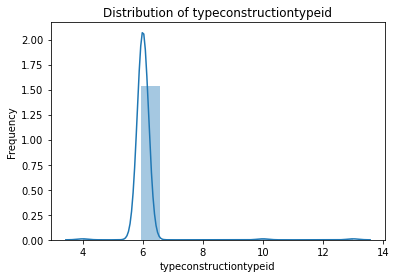

|------------------------------------------------------|
|------------------------------------------------------|
|-------unitcnt-------|

dtpye: float64

Null count: 26818

count    50563.000000
mean         1.110021
std          1.171154
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        237.000000
Name: unitcnt, dtype: float64

1.0      47293
2.0       2018
4.0        723
3.0        525
42.0         1
237.0        1
45.0         1
6.0          1
Name: unitcnt, dtype: int64

[ nan   1.   2.   3.   4.  45.  42.   6. 237.]



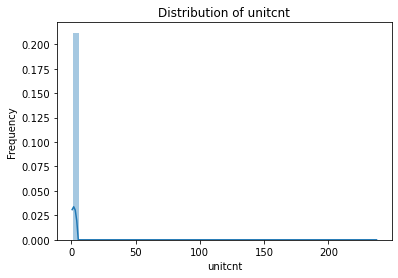

|------------------------------------------------------|
|------------------------------------------------------|
|-------yardbuildingsqft17-------|

dtpye: float64

Null count: 74993

count    2388.000000
mean      305.411223
std       238.392793
min        11.000000
25%       170.000000
50%       251.000000
75%       364.000000
max      3191.000000
Name: yardbuildingsqft17, dtype: float64

200.0     103
240.0      76
300.0      50
180.0      42
120.0      38
         ... 
1556.0      1
1011.0      1
640.0       1
131.0       1
706.0       1
Name: yardbuildingsqft17, Length: 540, dtype: int64

[  nan  306.  160.  318.  252.  196.  245.  260.  282.  345.  537. 2332.
  370. 2206.  300.  360.  244.  144.  320.  200.  420.  600.  432.  150.
  195.  566.  290.   80.  308.  270.   86.  312.  108.  780.  440.   98.
  100.  175.  628.  231.  264.  120.  236.  250.  240.  288.  256.  280.
  146.  481.  392.  221.   90.  575.  378.  140.  180.   83.   79.  352.
  568.  567.  113.  361.  112.  4

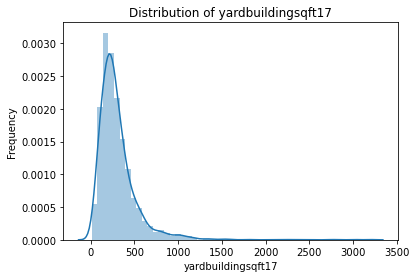

|------------------------------------------------------|
|------------------------------------------------------|
|-------yardbuildingsqft26-------|

dtpye: float64

Null count: 77311

count     70.000000
mean     216.385714
std      190.177514
min       12.000000
25%       61.500000
50%      164.500000
75%      310.500000
max      868.000000
Name: yardbuildingsqft26, dtype: float64

30.0     3
120.0    3
448.0    2
300.0    2
56.0     2
240.0    2
88.0     2
33.0     2
144.0    2
204.0    1
218.0    1
60.0     1
461.0    1
336.0    1
414.0    1
180.0    1
284.0    1
216.0    1
868.0    1
368.0    1
292.0    1
39.0     1
45.0     1
196.0    1
575.0    1
37.0     1
48.0     1
314.0    1
320.0    1
491.0    1
16.0     1
66.0     1
752.0    1
160.0    1
384.0    1
231.0    1
576.0    1
41.0     1
91.0     1
174.0    1
71.0     1
49.0     1
140.0    1
648.0    1
195.0    1
72.0     1
12.0     1
113.0    1
21.0     1
462.0    1
169.0    1
200.0    1
105.0    1
486.0    1
133.0    1
360.0   

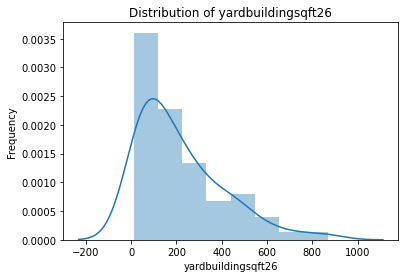

|------------------------------------------------------|
|------------------------------------------------------|
|-------yearbuilt-------|

dtpye: float64

Null count: 263

count    77118.000000
mean      1968.635831
std         23.786032
min       1824.000000
25%       1953.000000
50%       1970.000000
75%       1987.000000
max       2016.000000
Name: yearbuilt, dtype: float64

1955.0    1969
1989.0    1787
1950.0    1673
1964.0    1642
1954.0    1583
          ... 
1894.0       1
1880.0       1
1878.0       1
1882.0       1
1866.0       1
Name: yearbuilt, Length: 136, dtype: int64

[1998. 1967. 1962. 1970. 1964. 1982. 1950. 1922. 1980. 1999. 1973. 1989.
 2004. 1981. 1939. 1979. 1978. 1908. 1983. 1944. 1972. 1920. 1992. 2009.
 1977.   nan 1952. 1951. 1948. 1941. 1928. 1901. 1991. 2006. 1953. 2007.
 1987. 2000. 1958. 2014. 1984. 1956. 1917. 1946. 1955. 1997. 1885. 1919.
 1963. 1971. 1985. 1940. 1938. 1961. 1974. 2013. 1937. 1994. 1954. 1966.
 1923. 1929. 1926. 1969. 1988. 1911. 1957. 

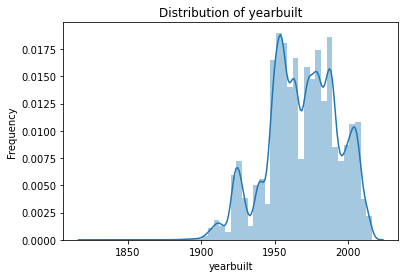

|------------------------------------------------------|
|------------------------------------------------------|
|-------numberofstories-------|

dtpye: float64

Null count: 59821

count    17560.000000
mean         1.434738
std          0.544569
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          6.000000
Name: numberofstories, dtype: float64

1.0    10366
2.0     6757
3.0      436
6.0        1
Name: numberofstories, dtype: int64

[nan  1.  2.  3.  6.]



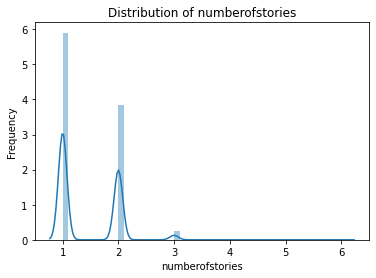

|------------------------------------------------------|
|------------------------------------------------------|
|-------fireplaceflag-------|

dtpye: float64

Null count: 77209

count    172.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: fireplaceflag, dtype: float64

1.0    172
Name: fireplaceflag, dtype: int64

[nan  1.]



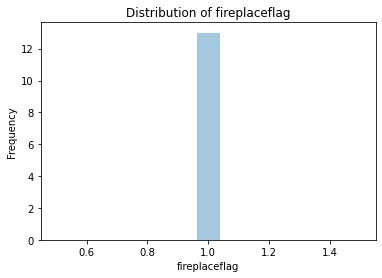

|------------------------------------------------------|
|------------------------------------------------------|
|-------structuretaxvaluedollarcnt-------|

dtpye: float64

Null count: 112

count    7.726900e+04
mean     1.893145e+05
std      2.300874e+05
min      4.400000e+01
25%      8.426500e+04
50%      1.364990e+05
75%      2.187870e+05
max      1.142179e+07
Name: structuretaxvaluedollarcnt, dtype: float64

100000.0    82
200000.0    58
203050.0    55
90000.0     52
101525.0    49
            ..
482109.0     1
57945.0      1
116757.0     1
105827.0     1
154255.0     1
Name: structuretaxvaluedollarcnt, Length: 50430, dtype: int64

[485713.  88000.  85289. ...  70917.  32797.  77118.]



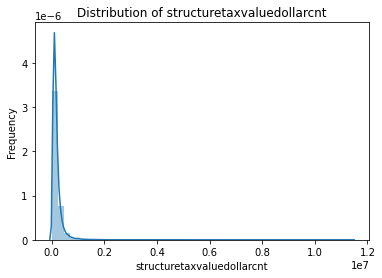

|------------------------------------------------------|
|------------------------------------------------------|
|-------taxvaluedollarcnt-------|

dtpye: float64

Null count: 1

count    7.738000e+04
mean     4.901345e+05
std      6.534440e+05
min      1.000000e+03
25%      2.070000e+05
50%      3.589755e+05
75%      5.690015e+05
max      4.906124e+07
Name: taxvaluedollarcnt, dtype: float64

400000.0    56
600000.0    50
350000.0    49
450000.0    45
500000.0    43
            ..
466022.0     1
78418.0      1
499402.0     1
237157.0     1
134063.0     1
Name: taxvaluedollarcnt, Length: 50949, dtype: int64

[1023282.  464000.  564778. ...   67205.   49546.  259334.]



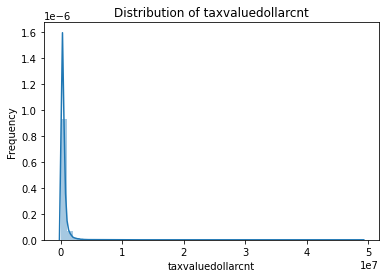

|------------------------------------------------------|
|------------------------------------------------------|
|-------assessmentyear-------|

dtpye: float64

Null count: 0

count    77381.0
mean      2016.0
std          0.0
min       2016.0
25%       2016.0
50%       2016.0
75%       2016.0
max       2016.0
Name: assessmentyear, dtype: float64

2016.0    77381
Name: assessmentyear, dtype: int64

[2016.]



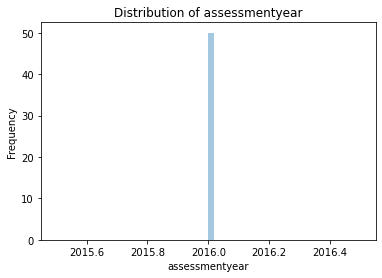

|------------------------------------------------------|
|------------------------------------------------------|
|-------landtaxvaluedollarcnt-------|

dtpye: float64

Null count: 2

count    7.737900e+04
mean     3.010954e+05
std      4.925960e+05
min      1.610000e+02
25%      8.550400e+04
50%      2.033720e+05
75%      3.667965e+05
max      4.895220e+07
Name: landtaxvaluedollarcnt, dtype: float64

21299.0     97
22755.0     68
304575.0    65
203050.0    63
30210.0     63
            ..
588520.0     1
181416.0     1
604261.0     1
443355.0     1
365784.0     1
Name: landtaxvaluedollarcnt, Length: 51600, dtype: int64

[537569. 376000. 479489. ... 214889. 221068. 283704.]



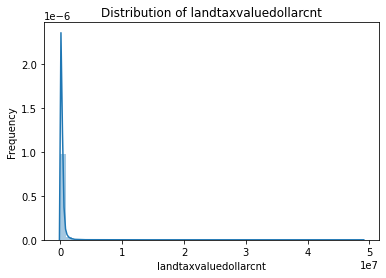

|------------------------------------------------------|
|------------------------------------------------------|
|-------taxamount-------|

dtpye: float64

Null count: 5

count     77376.000000
mean       5995.532346
std        7622.844153
min          19.920000
25%        2715.632500
50%        4450.695000
75%        6927.790000
max      586639.300000
Name: taxamount, dtype: float64

2418.22     8
3720.52     7
1725.20     5
3815.22     5
2217.31     5
           ..
7560.46     1
938.89      1
4648.57     1
5377.12     1
21590.39    1
Name: taxamount, Length: 73825, dtype: int64

[11013.72  5672.48  6488.3  ...   876.43  6317.15  3345.78]



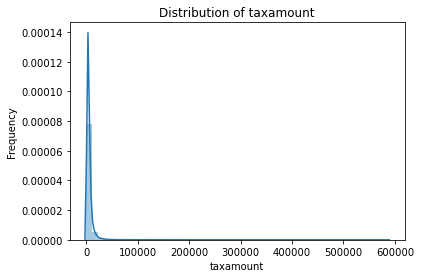

|------------------------------------------------------|
|------------------------------------------------------|
|-------taxdelinquencyflag-------|

dtpye: object

Null count: 74495

count     2886
unique       1
top          Y
freq      2886
Name: taxdelinquencyflag, dtype: object

Y    2886
Name: taxdelinquencyflag, dtype: int64

[nan 'Y']

|------------------------------------------------------|
|------------------------------------------------------|
|-------taxdelinquencyyear-------|

dtpye: float64

Null count: 74495

count    2886.000000
mean       14.087318
std         2.185663
min         3.000000
25%        14.000000
50%        15.000000
75%        15.000000
max        99.000000
Name: taxdelinquencyyear, dtype: float64

15.0    1552
14.0     799
13.0     183
12.0     113
11.0      98
10.0      66
9.0       47
8.0       14
7.0       10
4.0        1
3.0        1
99.0       1
6.0        1
Name: taxdelinquencyyear, dtype: int64

[nan 15. 14.  9. 11. 10. 13. 12.  3.  7.  6.  8. 9

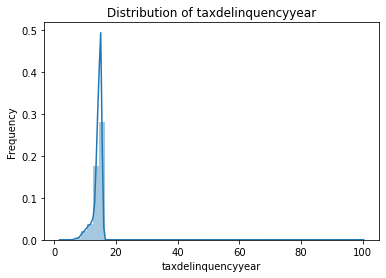

|------------------------------------------------------|
|------------------------------------------------------|
|-------censustractandblock-------|

dtpye: float64

Null count: 244

count    7.713700e+04
mean     6.049673e+13
std      1.535242e+12
min      6.037101e+13
25%      6.037311e+13
50%      6.037603e+13
75%      6.059042e+13
max      4.830301e+14
Name: censustractandblock, dtype: float64

6.037137e+13    60
6.037277e+13    51
6.059032e+13    44
6.037920e+13    41
6.059063e+13    41
                ..
6.037461e+13     1
6.059076e+13     1
6.037403e+13     1
6.037901e+13     1
6.037311e+13     1
Name: censustractandblock, Length: 39006, dtype: int64

[6.05906301e+13 6.11100100e+13 6.05902180e+13 ... 6.03755480e+13
 6.11100840e+13 6.03750340e+13]



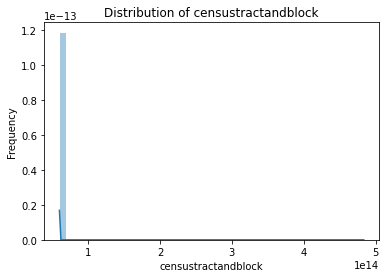

|------------------------------------------------------|
|------------------------------------------------------|
|-------airconditioningdesc-------|

dtpye: object

Null count: 52428

count       24953
unique          5
top       Central
freq        23133
Name: airconditioningdesc, dtype: object

Central          23133
Yes               1574
None               167
Wall Unit           53
Refrigeration       26
Name: airconditioningdesc, dtype: int64

[nan 'Central' 'Yes' 'None' 'Wall Unit' 'Refrigeration']

|------------------------------------------------------|
|------------------------------------------------------|
|-------transactiondate-------|

dtpye: object

Null count: 0

count          77381
unique           265
top       2017-06-30
freq            1189
Name: transactiondate, dtype: object

2017-06-30    1189
2017-04-28     911
2017-05-31     867
2017-07-28     814
2017-08-31     781
              ... 
2017-08-05       1
2018-05-25       1
2017-03-12       1
2017-04-15       

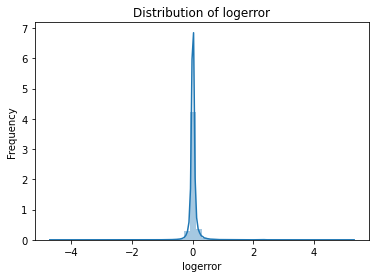

|------------------------------------------------------|
|------------------------------------------------------|
|-------architecturalstyledesc-------|

dtpye: object

Null count: 77175

count              206
unique               5
top       Contemporary
freq               172
Name: architecturalstyledesc, dtype: object

Contemporary     172
Conventional      19
Ranch/Rambler      7
Bungalow           5
Cape Cod           3
Name: architecturalstyledesc, dtype: int64

[nan 'Contemporary' 'Conventional' 'Ranch/Rambler' 'Cape Cod' 'Bungalow']

|------------------------------------------------------|
|------------------------------------------------------|
|-------buildingclassdesc-------|

dtpye: object

Null count: 77366

count                                                 15
unique                                                 2
top       Buildings having wood or wood and steel frames
freq                                                  14
Name: buildingclassdesc, dtype: object



In [9]:
def summarize_stats(df):
    print("YOU CAN'T HANDLE THE STATS!!!!!!")
    print('|------------------------------------------------------|')
    print('|------------------------------------------------------|')
    print(f'Shape: {df.shape}')
    print('|------------------------------------------------------|')
    print(df.info())
    print('|------------------------------------------------------|')
    print('|------------------------------------------------------|')
    for col in df.columns:
        print(f'|-------{col}-------|')
        print()
        print(f'dtpye: {df[col].dtype}')
        print()
        print(f'Null count: {df[col].isnull().sum()}')
        print()
        print(df[col].describe())
        print()
        print(df[col].value_counts())
        print()
        print(df[col].unique())
        print()
        if df[col].dtype != 'O':
            sns.distplot(df[col])
            plt.title(f'Distribution of {col}')
            plt.ylabel('Frequency')
            plt.xlabel(col)
            plt.show()
        print('|------------------------------------------------------|')
        print('|------------------------------------------------------|')
summarize_stats(df)

In [10]:
def nulls_by_col(df):
    num_missing = df.isnull().sum()
    rows = df.shape[0]
    prcnt_miss = num_missing / rows * 100
    cols_missing = pd.DataFrame({'num_rows_missing': num_missing, 'percent_rows_missing': prcnt_miss})
    return cols_missing
nulls_by_col(df)

,num_rows_missing,percent_rows_missing
id,0,0.000000
parcelid,0,0.000000
airconditioningtypeid,52428,67.753066
architecturalstyletypeid,77175,99.733785
basementsqft,77331,99.935385
...,...,...
buildingclassdesc,77366,99.980615
heatingorsystemdesc,27941,36.108347
propertylandusedesc,0,0.000000
storydesc,77331,99.935385


#### Takeaways

- for columns missing more than 75% of values missing, these will be dropped

In [11]:
def nulls_by_row(df):
    num_missing = df.isnull().sum(axis=1)
    prcnt_miss = num_missing / df.shape[1] * 100
    rows_missing = pd.DataFrame({'num_cols_missing': num_missing, 'percent_cols_missing': prcnt_miss})\
    .reset_index()\
    .groupby(['num_cols_missing', 'percent_cols_missing']).count()\
    .rename(index=str, columns={'index': 'num_rows'}).reset_index()
    return rows_missing
nulls_by_row(df)

,num_cols_missing,percent_cols_missing,num_rows
0,23,33.82352941176471,2
1,24,35.294117647058826,13
2,25,36.76470588235294,24
3,26,38.23529411764706,65
4,27,39.705882352941174,316
5,28,41.17647058823529,455
6,29,42.64705882352941,5270
7,30,44.11764705882353,3455
8,31,45.588235294117645,9891
9,32,47.05882352941176,12579


#### Takeaways

- for rows missing more than 50% of values missing, these will be dropped

## Prepare
1. Remove any properties that are likely to be something other than single unit properties. (e.g. no duplexes, no land/lot, ...). There are multiple ways to estimate that a property is a single unit, and there is not a single "right" answer. But for this exercise, do not purely filter by unitcnt as we did previously. Add some new logic that will reduce the number of properties that are falsely removed. You might want to use # bedrooms, square feet, unit type or the like to then identify those with unitcnt not defined.

2. Create a function that will drop rows or columns based on the percent of values that are missing: handle_missing_values(df, prop_required_column, prop_required_row).
    - The input:
        - A dataframe
        - A number between 0 and 1 that represents the proportion, for each column, of rows with non-missing values required to keep the column. i.e. if prop_required_column = .6, then you are requiring a column to have at least 60% of values not-NA (no more than 40% missing).
        - A number between 0 and 1 that represents the proportion, for each row, of columns/variables with non-missing values required to keep the row. For example, if prop_required_row = .75, then you are requiring a row to have at least 75% of variables with a non-missing value (no more that 25% missing).
    - The output:
        - The dataframe with the columns and rows dropped as indicated. Be sure to drop the columns prior to the rows in your function.
    - hint:
        - Look up the dropna documentation.
        - You will want to compute a threshold from your input values (prop_required) and total number of rows or columns.
        - Make use of inplace, i.e. inplace=True/False.
        
3. Decide how to handle the remaining missing values:
    - Fill with constant value.
    - Impute with mean, median, mode.
    - Drop row/column

In [12]:
# Single Unit Properties
def single_unit_props(df):
    df = df[(df.propertylandusetypeid==261) | 
            (df.propertylandusetypeid==263) | 
            (df.propertylandusetypeid==264) | 
            (df.propertylandusetypeid==265) | 
            (df.propertylandusetypeid==266) | 
            (df.propertylandusetypeid==275) | 
            (df.unitcnt==1)]
    return df
df = single_unit_props(df)

In [13]:
def handle_missing_values(df, prop_required_column=0.75, prop_required_row=0.5):
    df.dropna(axis=0, thresh=df.shape[1]*prop_required_row, inplace=True)
    df.dropna(axis=1, thresh=df.shape[0]*prop_required_column, inplace=True)
    return df
df = handle_missing_values(df)
df

,id,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,transactiondate,logerror,heatingorsystemdesc,propertylandusedesc
1,1387261,17052889,1.0,2.0,NaN,1.0,1465.0,1465.0,6111.0,1.0,...,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,2017-01-01,0.055619,NaN,Single Family Residential
2,11677,14186244,2.0,3.0,NaN,2.0,1243.0,1243.0,6059.0,2.0,...,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,2017-01-01,0.005383,NaN,Single Family Residential
3,2288172,12177905,3.0,4.0,8.0,3.0,2376.0,2376.0,6037.0,3.0,...,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,2017-01-01,-0.103410,Central,Single Family Residential
4,1970746,10887214,3.0,3.0,8.0,3.0,1312.0,1312.0,6037.0,3.0,...,73681.0,119407.0,2016.0,45726.0,1533.89,6.037124e+13,2017-01-01,0.006940,Central,Condominium
5,1447245,17143294,2.0,3.0,NaN,2.0,1492.0,1492.0,6111.0,2.0,...,198640.0,331064.0,2016.0,132424.0,3508.10,6.111005e+13,2017-01-01,-0.020526,NaN,Condominium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77376,673515,11000655,2.0,2.0,6.0,2.0,1286.0,1286.0,6037.0,2.0,...,70917.0,354621.0,2016.0,283704.0,4478.43,6.037101e+13,2017-09-20,0.020615,Central,Single Family Residential
77377,2968375,17239384,2.0,4.0,NaN,2.0,1612.0,1612.0,6111.0,2.0,...,50683.0,67205.0,2016.0,16522.0,1107.48,6.111008e+13,2017-09-21,0.013209,NaN,Single Family Residential
77378,1843709,12773139,1.0,3.0,4.0,1.0,1032.0,1032.0,6037.0,1.0,...,32797.0,49546.0,2016.0,16749.0,876.43,6.037434e+13,2017-09-21,0.037129,Central,Single Family Residential
77379,1187175,12826780,2.0,3.0,6.0,2.0,1762.0,1762.0,6037.0,2.0,...,140000.0,522000.0,2016.0,382000.0,6317.15,6.037503e+13,2017-09-25,0.007204,Central,Single Family Residential


In [14]:
def drop_useless(df, useless_cols):
    df.drop(columns=useless_cols, inplace=True)
    return df
drop_useless(df, ['id', 'parcelid'])

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,heatingorsystemtypeid,latitude,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,transactiondate,logerror,heatingorsystemdesc,propertylandusedesc
1,1.0,2.0,NaN,1.0,1465.0,1465.0,6111.0,1.0,NaN,34449266.0,...,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,2017-01-01,0.055619,NaN,Single Family Residential
2,2.0,3.0,NaN,2.0,1243.0,1243.0,6059.0,2.0,NaN,33886168.0,...,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,2017-01-01,0.005383,NaN,Single Family Residential
3,3.0,4.0,8.0,3.0,2376.0,2376.0,6037.0,3.0,2.0,34245180.0,...,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,2017-01-01,-0.103410,Central,Single Family Residential
4,3.0,3.0,8.0,3.0,1312.0,1312.0,6037.0,3.0,2.0,34185120.0,...,73681.0,119407.0,2016.0,45726.0,1533.89,6.037124e+13,2017-01-01,0.006940,Central,Condominium
5,2.0,3.0,NaN,2.0,1492.0,1492.0,6111.0,2.0,NaN,34230044.0,...,198640.0,331064.0,2016.0,132424.0,3508.10,6.111005e+13,2017-01-01,-0.020526,NaN,Condominium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77376,2.0,2.0,6.0,2.0,1286.0,1286.0,6037.0,2.0,2.0,34245368.0,...,70917.0,354621.0,2016.0,283704.0,4478.43,6.037101e+13,2017-09-20,0.020615,Central,Single Family Residential
77377,2.0,4.0,NaN,2.0,1612.0,1612.0,6111.0,2.0,NaN,34300140.0,...,50683.0,67205.0,2016.0,16522.0,1107.48,6.111008e+13,2017-09-21,0.013209,NaN,Single Family Residential
77378,1.0,3.0,4.0,1.0,1032.0,1032.0,6037.0,1.0,2.0,34040895.0,...,32797.0,49546.0,2016.0,16749.0,876.43,6.037434e+13,2017-09-21,0.037129,Central,Single Family Residential
77379,2.0,3.0,6.0,2.0,1762.0,1762.0,6037.0,2.0,2.0,33937685.0,...,140000.0,522000.0,2016.0,382000.0,6317.15,6.037503e+13,2017-09-25,0.007204,Central,Single Family Residential


In [15]:
def cols_missing_10000(df, new_col_thresh=10_000):
    remove_cols=[]
    for col in df.columns:
        if df[col].isnull().sum() > new_col_thresh:
            remove_cols.append(col)
    df.drop(columns=remove_cols, inplace=True)
    return df
cols_missing_10000(df)

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,transactiondate,logerror,propertylandusedesc
1,1.0,2.0,1.0,1465.0,1465.0,6111.0,1.0,34449266.0,-119281531.0,12647.0,...,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,2017-01-01,0.055619,Single Family Residential
2,2.0,3.0,2.0,1243.0,1243.0,6059.0,2.0,33886168.0,-117823170.0,8432.0,...,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,2017-01-01,0.005383,Single Family Residential
3,3.0,4.0,3.0,2376.0,2376.0,6037.0,3.0,34245180.0,-118240722.0,13038.0,...,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,2017-01-01,-0.103410,Single Family Residential
4,3.0,3.0,3.0,1312.0,1312.0,6037.0,3.0,34185120.0,-118414640.0,278581.0,...,1964.0,73681.0,119407.0,2016.0,45726.0,1533.89,6.037124e+13,2017-01-01,0.006940,Condominium
5,2.0,3.0,2.0,1492.0,1492.0,6111.0,2.0,34230044.0,-118993991.0,903.0,...,1982.0,198640.0,331064.0,2016.0,132424.0,3508.10,6.111005e+13,2017-01-01,-0.020526,Condominium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77376,2.0,2.0,2.0,1286.0,1286.0,6037.0,2.0,34245368.0,-118282383.0,47405.0,...,1940.0,70917.0,354621.0,2016.0,283704.0,4478.43,6.037101e+13,2017-09-20,0.020615,Single Family Residential
77377,2.0,4.0,2.0,1612.0,1612.0,6111.0,2.0,34300140.0,-118706327.0,12105.0,...,1964.0,50683.0,67205.0,2016.0,16522.0,1107.48,6.111008e+13,2017-09-21,0.013209,Single Family Residential
77378,1.0,3.0,1.0,1032.0,1032.0,6037.0,1.0,34040895.0,-118038169.0,5074.0,...,1954.0,32797.0,49546.0,2016.0,16749.0,876.43,6.037434e+13,2017-09-21,0.037129,Single Family Residential
77379,2.0,3.0,2.0,1762.0,1762.0,6037.0,2.0,33937685.0,-117996709.0,6347.0,...,1955.0,140000.0,522000.0,2016.0,382000.0,6317.15,6.037503e+13,2017-09-25,0.007204,Single Family Residential


In [16]:
def impute_mode(df, cols_to_fill):
    for col in cols_to_fill:
        df[col].fillna(df[col].mode()[0], inplace=True)
    return df
df = impute_mode(df, ['calculatedbathnbr', 'finishedsquarefeet12', 'fullbathcnt', 'regionidcity', 'regionidzip', 'yearbuilt'])

In [17]:
def impute_median(df, cols_to_fill):
    for col in cols_to_fill:
        df[col].fillna(df[col].median(), inplace=True)
    return df
df = impute_median(df, ['censustractandblock', 'taxamount', 'structuretaxvaluedollarcnt', 'lotsizesquarefeet', 'calculatedfinishedsquarefeet'])

In [18]:
df

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,transactiondate,logerror,propertylandusedesc
1,1.0,2.0,1.0,1465.0,1465.0,6111.0,1.0,34449266.0,-119281531.0,12647.0,...,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,2017-01-01,0.055619,Single Family Residential
2,2.0,3.0,2.0,1243.0,1243.0,6059.0,2.0,33886168.0,-117823170.0,8432.0,...,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,2017-01-01,0.005383,Single Family Residential
3,3.0,4.0,3.0,2376.0,2376.0,6037.0,3.0,34245180.0,-118240722.0,13038.0,...,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,2017-01-01,-0.103410,Single Family Residential
4,3.0,3.0,3.0,1312.0,1312.0,6037.0,3.0,34185120.0,-118414640.0,278581.0,...,1964.0,73681.0,119407.0,2016.0,45726.0,1533.89,6.037124e+13,2017-01-01,0.006940,Condominium
5,2.0,3.0,2.0,1492.0,1492.0,6111.0,2.0,34230044.0,-118993991.0,903.0,...,1982.0,198640.0,331064.0,2016.0,132424.0,3508.10,6.111005e+13,2017-01-01,-0.020526,Condominium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77376,2.0,2.0,2.0,1286.0,1286.0,6037.0,2.0,34245368.0,-118282383.0,47405.0,...,1940.0,70917.0,354621.0,2016.0,283704.0,4478.43,6.037101e+13,2017-09-20,0.020615,Single Family Residential
77377,2.0,4.0,2.0,1612.0,1612.0,6111.0,2.0,34300140.0,-118706327.0,12105.0,...,1964.0,50683.0,67205.0,2016.0,16522.0,1107.48,6.111008e+13,2017-09-21,0.013209,Single Family Residential
77378,1.0,3.0,1.0,1032.0,1032.0,6037.0,1.0,34040895.0,-118038169.0,5074.0,...,1954.0,32797.0,49546.0,2016.0,16749.0,876.43,6.037434e+13,2017-09-21,0.037129,Single Family Residential
77379,2.0,3.0,2.0,1762.0,1762.0,6037.0,2.0,33937685.0,-117996709.0,6347.0,...,1955.0,140000.0,522000.0,2016.0,382000.0,6317.15,6.037503e+13,2017-09-25,0.007204,Single Family Residential
